# Importing librarries and setup

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import ast
from nltk.stem import WordNetLemmatizer
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/text_classification_with_CNN/20_newsgroups/

/content/drive/MyDrive/text_classification_with_CNN/20_newsgroups/20_newsgroups


In [ ]:
%pwd

'/content/drive/MyDrive/text_classification_with_CNN/20_newsgroups'

#Preprocessing

## Loading Data

In [ ]:
# Set the path to your 20 Newsgroups dataset
dataset_path = "/content/drive/MyDrive/text_classification_with_CNN/20_newsgroups"

# Initialize empty lists to store text and labels
texts = []
labels = []

# Traverse the directory structure
for label in tqdm(os.listdir(dataset_path)):
    label_path = os.path.join(dataset_path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
        # Iterate over files in the label directory
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)

            # Read the content of each document
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                content = file.read()

            # Append the text and label to the lists
            texts.append(content)
            labels.append(label)

# Create a Pandas DataFrame
df = pd.DataFrame({'Text': texts, 'Label': labels})

100%|██████████| 21/21 [07:36<00:00, 21.74s/it]


## Know Your data

In [ ]:
df.head()

,Text,Label
0,Newsgroups: comp.sys.ibm.pc.hardware\nPath: ca...,comp.sys.ibm.pc.hardware
1,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,comp.sys.ibm.pc.hardware
2,Newsgroups: comp.sys.ibm.pc.hardware\nPath: ca...,comp.sys.ibm.pc.hardware
3,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,comp.sys.ibm.pc.hardware
4,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,comp.sys.ibm.pc.hardware


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19997 non-null  object
 1   Label   19997 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


# Label distribution:

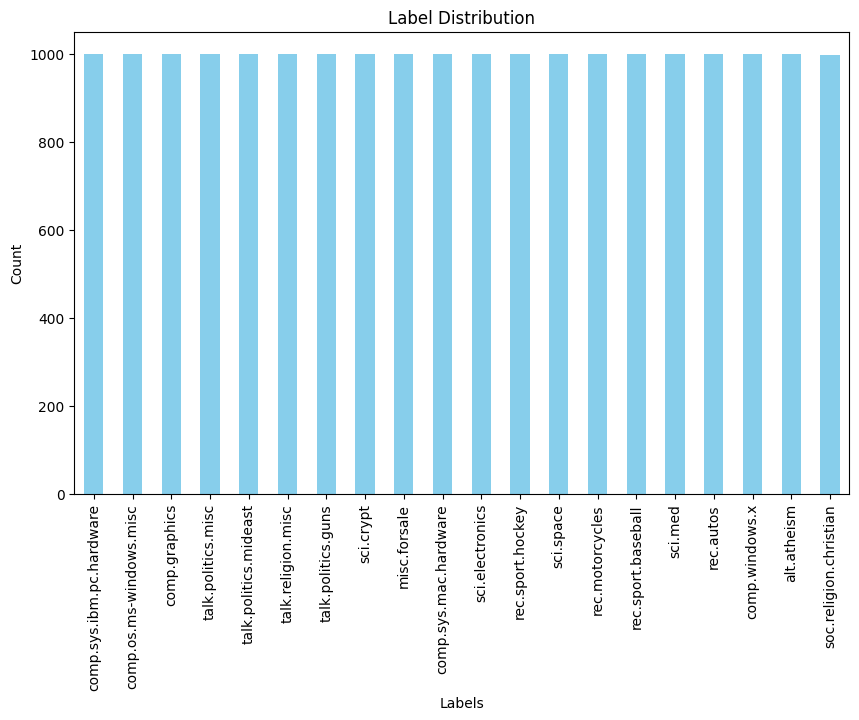

In [ ]:
plt.figure(figsize=(10, 6))
df['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [ ]:
cnt = 0
for t in df.groupby("Label").sample(n=1, random_state=42)["Text"]:
  print(t)
  cnt += 1
  if(cnt == 15): #dont want to mess output so limit 15
    break

Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:120549 alt.atheism:53102 talk.religion.misc:83565
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!darwin.sura.net!sgiblab!sgigate!odin!fido!solntze.wpd.sgi.com!livesey
From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Newsgroups: talk.abortion,alt.atheism,talk.religion.misc
Subject: Re: After 2000 years, can we say that Christian Morality is
Date: 15 Apr 1993 22:26:02 GMT
Organization: sgi
Lines: 14
Distribution: world
Message-ID: <1qkndq$k@fido.asd.sgi.com>
References: <30114@ursa.bear.com> <1qie61$fkt@horus.ap.mchp.sni.de> <kmr4.1571.734847050@po.CWRU.edu> <1qjbn0$na4@horus.ap.mchp.sni.de>
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qjbn0$na4@horus.ap.mchp.sni.de>, frank@D012S658.uucp (Frank O'Dwyer) writes:
|> In article <kmr4.1571.734847050@po.CWRU.edu> kmr4@po.CWRU.edu (Keith M. Ryan) writes:
|> #	You have only pushed back the undefined meaning. You must now defi

In [ ]:
# prompt: convert all data of df to lowercase text and label both

df.Text = df.Text.str.lower()
df.Label = df.Label.str.lower()


NameError: name 'df' is not defined

In [ ]:
import re

In [ ]:
header_pattern = re.compile(r'^\S+:(.*?(\n\s*\n|$))', re.MULTILINE | re.DOTALL)

df_preprocessed = df.copy()
df_preprocessed['Text'] = df_preprocessed['Text'].str.replace(header_pattern, '')
df_preprocessed.head()


,Text,Label
0,"\n\n\n\n\n\n\n\n hi all,\n\n i have heard th...",comp.sys.ibm.pc.hardware
1,\n\n\n\n\n\n\n\n\n\n\nbruce maynard (drac@uume...,comp.sys.ibm.pc.hardware
2,\n\n\n\n\n\n\n\n\n<guf@psuvm.psu.edu> writes:\...,comp.sys.ibm.pc.hardware
3,\n\n\n\n\n\n\n\n\n\nhello. i hope somebody ou...,comp.sys.ibm.pc.hardware
4,\n\n\n\n\n\n\n\n\n\ni think it would be a grea...,comp.sys.ibm.pc.hardware


In [ ]:
# prompt: print text of one sample from df and one from df_preprocessed of each 20 label doing this for comparison

for label in df.Label.unique():
  print(df[df.Label == label].sample(n=1, random_state=42)["Text"].values[0])
  print(df_preprocessed[df_preprocessed.Label == label].sample(n=1, random_state=42)["Text"].values[0])

path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!darwin.sura.net!haven.umd.edu!news.umbc.edu!nobody
from: andrew@hotelca.tech.umbc.edu (andrew williams)
newsgroups: comp.sys.ibm.pc.hardware
subject: error beeps on boot
date: 22 apr 1993 15:54:38 -0400
organization: university of maryland, baltimore county campus
lines: 15
message-id: <1r6t5uinn23v@hotelca.tech.umbc.edu>
nntp-posting-host: hotelca.tech.umbc.edu

i am servicing a machine (hp-286) and whenever the thing starts up i get
4 beeps on powerup.  does anyone know what error message that signifies?  i 
don't seem to have any problem with the machine but the lady who is using it
is "very concerned" about it.  

don't you just love hp computers???

preferr responses by e-mail but i read the net so you can post it here.

-------
andrew
acs micro-computer & network technical support
university of maryland baltimore county
andrew@hotelca.tech.umbc.edu










i am servicing a machine (hp-286) 

In [ ]:
# prompt: print one sample from each label in df_preprocessed data

for label in df_preprocessed.Label.unique():
  print(df_preprocessed[df_preprocessed.Label == label].sample(n=1, random_state=42)["Text"].values[0])









i am servicing a machine (hp-286) and whenever the thing starts up i get
4 beeps on powerup.  does anyone know what error message that signifies?  i 
don't seem to have any problem with the machine but the lady who is using it
is "very concerned" about it.  

don't you just love hp computers???

preferr responses by e-mail but i read the net so you can post it here.

-------
andrew
acs micro-computer & network technical support
university of maryland baltimore county
andrew@hotelca.tech.umbc.edu











ecktons@ucs.byu.edu (sean eckton) writes:

>i have a microsoft serial mouse and am using mouse.com 8.00 (was using 8.20 
>i think, but switched to 8.00 to see if it was any better).  vertical motion 
>is nice and smooth, but horizontal motion is so bad i sometimes can't click 
>on something because my mouse jumps around.  i can be moving the mouse to 
>the right with relatively uniform motion and the mouse will move smoothly 
>for a bit, then jump to the right, then move smoo

## Correcting Emails

In [ ]:
# correcting emails(having words of email and removing the spacial symbols within it)

def replace_emails(text):
    # Use regular expression to find and replace email addresses
    modified_text = re.sub(r'\b\S+@\S+\.\S+\b', lambda match: ' '.join(match.group().split('@')).replace('.', ' '), text)
    return modified_text

In [ ]:
text = replace_emails(
    '''












>in article <1993apr22.145940.1@skcla.monsanto.com> mas@skcla.monsanto.com writes:
>>if you put a locking lugnut on your tires, do you need to have your
>>tires rebalanced??
>>
>>john mas
>>
>>
>>e-mail address     ::     mas@skcla.monsanto.com
>>
>

i bought a set of are's a few months back and decided to add locks
so that i could keep my new rims. i haven't had a balance problem
yet so i assume that it might be just particular to your type of
stock nuts. my rims were balanced with new bfg t/a's at a speed
shop to the finest setting on their bal. machine, so that helps too.

zauberer aka. travis t.











    '''
)

In [ ]:
print(text)














>in article <1993apr22 145940 1 skcla monsanto com> mas skcla monsanto com writes:
>>if you put a locking lugnut on your tires, do you need to have your
>>tires rebalanced??
>>
>>john mas
>>
>>
>>e-mail address     ::     mas skcla monsanto com
>>
>

i bought a set of are's a few months back and decided to add locks
so that i could keep my new rims. i haven't had a balance problem
yet so i assume that it might be just particular to your type of
stock nuts. my rims were balanced with new bfg t/a's at a speed
shop to the finest setting on their bal. machine, so that helps too.

zauberer aka. travis t.











    


In [ ]:
df_preprocessed['Text'] = df_preprocessed['Text'].apply(replace_emails)

In [ ]:
# prompt: again add code for printing sample text of above

for label in df_preprocessed.Label.unique():
  print(df_preprocessed[df_preprocessed.Label == label].sample(n=1, random_state=2)["Text"].values[0])











35002_4401 uwovax uwo ca wrote:
: i need to know the pins to connect to make a loopback connector for a serial
: port so i can build one.  the loopback connector is used to test the 
: serial port.
: 
: thanks for any help.
: 
: 
: steve
: 
me too!!!!!!!
skcgoh tartarus uwa edu au










>
>i have little info on chicago so i cant make a comparison.  is it in beta?  is
>there anyone out there who has tested both and cares to make a comparison?
>just my $0.02  
>
>/aln
chicago from what i have read is projected to run in 4m on 386 and higher.
it is definitely aimed at the desktop. 
it  is rumored to offer preemptive multitasking,
multithreading but will not offer multiprocessing. is 32 bit and no reliance
on dos. it is rumored to have an integrated file and program manager. 
dos 7 is rumored to be similar to chicago but without the gui. is also
a step towards cairo (the next generation os) which is rumored to be 
object oriented.
i wonder where windows 4.0 fits here is it a 

## Remove special characters

In [ ]:
import re

def remove_special_characters(text):
    # Replace specific special characters with space, including |
    cleaned_text = re.sub(r'[?.,!@#$%^&*()_+={}\[\]:;<>/~`"|"-]', ' ', text)
    return cleaned_text


In [ ]:
# prompt: apply this remove_special_characters on the above df preprocessed

df_preprocessed['Text'] = df_preprocessed['Text'].apply(remove_special_characters)


In [ ]:
# prompt: print text as we were doing above

for label in df_preprocessed.Label.unique():
  print(df_preprocessed[df_preprocessed.Label == label].sample(n=1, random_state=42)["Text"].values[0])









i am servicing a machine  hp 286  and whenever the thing starts up i get
4 beeps on powerup   does anyone know what error message that signifies   i 
don't seem to have any problem with the machine but the lady who is using it
is  very concerned  about it   

don't you just love hp computers   

preferr responses by e mail but i read the net so you can post it here 

       
andrew
acs micro computer   network technical support
university of maryland baltimore county
andrew hotelca tech umbc edu











ecktons ucs byu edu  sean eckton  writes 

 i have a microsoft serial mouse and am using mouse com 8 00  was using 8 20 
 i think  but switched to 8 00 to see if it was any better    vertical motion 
 is nice and smooth  but horizontal motion is so bad i sometimes can't click 
 on something because my mouse jumps around   i can be moving the mouse to 
 the right with relatively uniform motion and the mouse will move smoothly 
 for a bit  then jump to the right  then move smoo

## Tokenization

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

# Assuming df is your DataFrame with a 'text' column
tqdm.pandas()
df_preprocessed['tokenized_text'] = df_preprocessed['Text'].progress_apply(lambda x: word_tokenize(x))

# Display the DataFrame with tokenized text
df_preprocessed[['Text', 'tokenized_text', 'Label']]

100%|██████████| 19997/19997 [00:28<00:00, 713.11it/s]


,Text,tokenized_text,Label
0,\n\n\n\n\n\n\n\n hi all \n\n i have heard th...,"[hi, all, i, have, heard, that, somewhere, the...",comp.sys.ibm.pc.hardware
1,\n\n\n\n\n\n\n\n\n\n\nbruce maynard drac uume...,"[bruce, maynard, drac, uumeme, chi, il, us, wr...",comp.sys.ibm.pc.hardware
2,\n\n\n\n\n\n\n\n\n guf psuvm psu edu writes \...,"[guf, psuvm, psu, edu, writes, i, own, an, 808...",comp.sys.ibm.pc.hardware
3,\n\n\n\n\n\n\n\n\n\nhello i hope somebody ou...,"[hello, i, hope, somebody, out, here, can, hel...",comp.sys.ibm.pc.hardware
4,\n\n\n\n\n\n\n\n\n\ni think it would be a grea...,"[i, think, it, would, be, a, great, idea, to, ...",comp.sys.ibm.pc.hardware
...,...,...,...
19992,\n\n\n\n\n\n\n\n\nbil okcforum osrhe edu bill...,"[bil, okcforum, osrhe, edu, bill, conner, writ...",alt.atheism
19993,\n\n\n\n\n\n\nbr from wpr atlanta dg com bi...,"[br, from, wpr, atlanta, dg, com, bill, rawlin...",alt.atheism
19994,\n\n\n\n\n\n\nrh from house helios usq edu a...,"[rh, from, house, helios, usq, edu, au, ron, h...",alt.atheism
19995,\n\n\n\n\n\n\n\n\n\nin article c5u7bq j43 new...,"[in, article, c5u7bq, j43, news, cso, uiuc, ed...",alt.atheism


## Stop Words Removal

In [ ]:
# Download NLTK stopwords resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tqdm.pandas()

# Define the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Apply the remove_stopwords function to the 'tokenized_text' column
df_preprocessed['tokenized_text_no_stopwords'] = df_preprocessed['tokenized_text'].progress_apply(remove_stopwords)

# Display the DataFrame with tokenized text and stopwords removed
df_preprocessed.head()


100%|██████████| 19997/19997 [00:02<00:00, 9541.24it/s]


,Text,Label,tokenized_text,tokenized_text_no_stopwords
0,\n\n\n\n\n\n\n\n hi all \n\n i have heard th...,comp.sys.ibm.pc.hardware,"[hi, all, i, have, heard, that, somewhere, the...","[hi, heard, somewhere, exist, programmable, ke..."
1,\n\n\n\n\n\n\n\n\n\n\nbruce maynard drac uume...,comp.sys.ibm.pc.hardware,"[bruce, maynard, drac, uumeme, chi, il, us, wr...","[bruce, maynard, drac, uumeme, chi, il, us, wr..."
2,\n\n\n\n\n\n\n\n\n guf psuvm psu edu writes \...,comp.sys.ibm.pc.hardware,"[guf, psuvm, psu, edu, writes, i, own, an, 808...","[guf, psuvm, psu, edu, writes, 8088, 640k, clo..."
3,\n\n\n\n\n\n\n\n\n\nhello i hope somebody ou...,comp.sys.ibm.pc.hardware,"[hello, i, hope, somebody, out, here, can, hel...","[hello, hope, somebody, help, currently, worki..."
4,\n\n\n\n\n\n\n\n\n\ni think it would be a grea...,comp.sys.ibm.pc.hardware,"[i, think, it, would, be, a, great, idea, to, ...","[think, would, great, idea, new, group, create..."


In [ ]:
# prompt: save df_preprocessed in the current directory as csv file
df_preprocessed.to_csv('preprocessed_data.csv')

In [ ]:
# prompt: read saved preprocessed_data.csv file and save as df_preprocessed

df_preprocessed = pd.read_csv('preprocessed_data.csv')

In [ ]:
df_preprocessed

,Unnamed: 0.1,Unnamed: 0,Text,Label,tokenized_text,tokenized_text_no_stopwords,lemmatized_text,text_combined
0,0,0,\n\n\n\n\n\n\n\n hi all \n\n i have heard th...,comp.sys.ibm.pc.hardware,"['hi', 'all', 'i', 'have', 'heard', 'that', 's...","['hi', 'heard', 'somewhere', 'exist', 'program...","['hi', 'heard', 'somewhere', 'exist', 'program...",hi heard somewhere exist programmable keyboard...
1,1,1,\n\n\n\n\n\n\n\n\n\n\nbruce maynard drac uume...,comp.sys.ibm.pc.hardware,"['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...","['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...","['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...",bruce maynard drac uumeme chi il u wrote artic...
2,2,2,\n\n\n\n\n\n\n\n\n guf psuvm psu edu writes \...,comp.sys.ibm.pc.hardware,"['guf', 'psuvm', 'psu', 'edu', 'writes', 'i', ...","['guf', 'psuvm', 'psu', 'edu', 'writes', '8088...","['guf', 'psuvm', 'psu', 'edu', 'writes', '8088...",guf psuvm psu edu writes 8088 640k clone want ...
3,3,3,\n\n\n\n\n\n\n\n\n\nhello i hope somebody ou...,comp.sys.ibm.pc.hardware,"['hello', 'i', 'hope', 'somebody', 'out', 'her...","['hello', 'hope', 'somebody', 'help', 'current...","['hello', 'hope', 'somebody', 'help', 'current...",hello hope somebody help currently working pro...
4,4,4,\n\n\n\n\n\n\n\n\n\ni think it would be a grea...,comp.sys.ibm.pc.hardware,"['i', 'think', 'it', 'would', 'be', 'a', 'grea...","['think', 'would', 'great', 'idea', 'new', 'gr...","['think', 'would', 'great', 'idea', 'new', 'gr...",think would great idea new group created comp ...
...,...,...,...,...,...,...,...,...
19992,19992,19992,\n\n\n\n\n\n\n\n\nbil okcforum osrhe edu bill...,alt.atheism,"['bil', 'okcforum', 'osrhe', 'edu', 'bill', 'c...","['bil', 'okcforum', 'osrhe', 'edu', 'bill', 'c...","['bil', 'okcforum', 'osrhe', 'edu', 'bill', 'c...",bil okcforum osrhe edu bill conner writes see ...
19993,19993,19993,\n\n\n\n\n\n\nbr from wpr atlanta dg com bi...,alt.atheism,"['br', 'from', 'wpr', 'atlanta', 'dg', 'com', ...","['br', 'wpr', 'atlanta', 'dg', 'com', 'bill', ...","['br', 'wpr', 'atlanta', 'dg', 'com', 'bill', ...",br wpr atlanta dg com bill rawlins br newsgrou...
19994,19994,19994,\n\n\n\n\n\n\nrh from house helios usq edu a...,alt.atheism,"['rh', 'from', 'house', 'helios', 'usq', 'edu'...","['rh', 'house', 'helios', 'usq', 'edu', 'au', ...","['rh', 'house', 'helios', 'usq', 'edu', 'au', ...",rh house helios usq edu au ron house rh newsgr...
19995,19995,19995,\n\n\n\n\n\n\n\n\n\nin article c5u7bq j43 new...,alt.atheism,"['in', 'article', 'c5u7bq', 'j43', 'news', 'cs...","['article', 'c5u7bq', 'j43', 'news', 'cso', 'u...","['article', 'c5u7bq', 'j43', 'news', 'cso', 'u...",article c5u7bq j43 news cso uiuc edu cobb alex...


## Lemmatization

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# prompt: apply WordNetLemmatizer on tokenized_text_no_stopwords with name of column lemmatized_text
lemmatizer = WordNetLemmatizer()

# Apply the lemmatizer to the 'tokenized_text_no_stopwords' column
df_preprocessed['lemmatized_text'] = df_preprocessed['tokenized_text_no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(token) for token in ast.literal_eval(x)])

# Display the DataFrame with lemmatized text
df_preprocessed.head()


,Unnamed: 0.1,Unnamed: 0,Text,Label,tokenized_text,tokenized_text_no_stopwords,lemmatized_text,text_combined
0,0,0,\n\n\n\n\n\n\n\n hi all \n\n i have heard th...,comp.sys.ibm.pc.hardware,"['hi', 'all', 'i', 'have', 'heard', 'that', 's...","['hi', 'heard', 'somewhere', 'exist', 'program...","[hi, heard, somewhere, exist, programmable, ke...",hi heard somewhere exist programmable keyboard...
1,1,1,\n\n\n\n\n\n\n\n\n\n\nbruce maynard drac uume...,comp.sys.ibm.pc.hardware,"['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...","['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...","[bruce, maynard, drac, uumeme, chi, il, u, wro...",bruce maynard drac uumeme chi il u wrote artic...
2,2,2,\n\n\n\n\n\n\n\n\n guf psuvm psu edu writes \...,comp.sys.ibm.pc.hardware,"['guf', 'psuvm', 'psu', 'edu', 'writes', 'i', ...","['guf', 'psuvm', 'psu', 'edu', 'writes', '8088...","[guf, psuvm, psu, edu, writes, 8088, 640k, clo...",guf psuvm psu edu writes 8088 640k clone want ...
3,3,3,\n\n\n\n\n\n\n\n\n\nhello i hope somebody ou...,comp.sys.ibm.pc.hardware,"['hello', 'i', 'hope', 'somebody', 'out', 'her...","['hello', 'hope', 'somebody', 'help', 'current...","[hello, hope, somebody, help, currently, worki...",hello hope somebody help currently working pro...
4,4,4,\n\n\n\n\n\n\n\n\n\ni think it would be a grea...,comp.sys.ibm.pc.hardware,"['i', 'think', 'it', 'would', 'be', 'a', 'grea...","['think', 'would', 'great', 'idea', 'new', 'gr...","[think, would, great, idea, new, group, create...",think would great idea new group created comp ...


## Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Assuming df_preprocessed is your DataFrame with 'lemmatized_text' and 'label' columns

# Combine the lemmatized tokens into a single string for each document
df_preprocessed['text_combined'] = df_preprocessed['lemmatized_text'].apply(lambda x: ' '.join(x))


In [ ]:
df_preprocessed

,Unnamed: 0.1,Unnamed: 0,Text,Label,tokenized_text,tokenized_text_no_stopwords,lemmatized_text,text_combined
0,0,0,\n\n\n\n\n\n\n\n hi all \n\n i have heard th...,comp.sys.ibm.pc.hardware,"['hi', 'all', 'i', 'have', 'heard', 'that', 's...","['hi', 'heard', 'somewhere', 'exist', 'program...","[hi, heard, somewhere, exist, programmable, ke...",hi heard somewhere exist programmable keyboard...
1,1,1,\n\n\n\n\n\n\n\n\n\n\nbruce maynard drac uume...,comp.sys.ibm.pc.hardware,"['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...","['bruce', 'maynard', 'drac', 'uumeme', 'chi', ...","[bruce, maynard, drac, uumeme, chi, il, u, wro...",bruce maynard drac uumeme chi il u wrote artic...
2,2,2,\n\n\n\n\n\n\n\n\n guf psuvm psu edu writes \...,comp.sys.ibm.pc.hardware,"['guf', 'psuvm', 'psu', 'edu', 'writes', 'i', ...","['guf', 'psuvm', 'psu', 'edu', 'writes', '8088...","[guf, psuvm, psu, edu, writes, 8088, 640k, clo...",guf psuvm psu edu writes 8088 640k clone want ...
3,3,3,\n\n\n\n\n\n\n\n\n\nhello i hope somebody ou...,comp.sys.ibm.pc.hardware,"['hello', 'i', 'hope', 'somebody', 'out', 'her...","['hello', 'hope', 'somebody', 'help', 'current...","[hello, hope, somebody, help, currently, worki...",hello hope somebody help currently working pro...
4,4,4,\n\n\n\n\n\n\n\n\n\ni think it would be a grea...,comp.sys.ibm.pc.hardware,"['i', 'think', 'it', 'would', 'be', 'a', 'grea...","['think', 'would', 'great', 'idea', 'new', 'gr...","[think, would, great, idea, new, group, create...",think would great idea new group created comp ...
...,...,...,...,...,...,...,...,...
19992,19992,19992,\n\n\n\n\n\n\n\n\nbil okcforum osrhe edu bill...,alt.atheism,"['bil', 'okcforum', 'osrhe', 'edu', 'bill', 'c...","['bil', 'okcforum', 'osrhe', 'edu', 'bill', 'c...","[bil, okcforum, osrhe, edu, bill, conner, writ...",bil okcforum osrhe edu bill conner writes see ...
19993,19993,19993,\n\n\n\n\n\n\nbr from wpr atlanta dg com bi...,alt.atheism,"['br', 'from', 'wpr', 'atlanta', 'dg', 'com', ...","['br', 'wpr', 'atlanta', 'dg', 'com', 'bill', ...","[br, wpr, atlanta, dg, com, bill, rawlins, br,...",br wpr atlanta dg com bill rawlins br newsgrou...
19994,19994,19994,\n\n\n\n\n\n\nrh from house helios usq edu a...,alt.atheism,"['rh', 'from', 'house', 'helios', 'usq', 'edu'...","['rh', 'house', 'helios', 'usq', 'edu', 'au', ...","[rh, house, helios, usq, edu, au, ron, house, ...",rh house helios usq edu au ron house rh newsgr...
19995,19995,19995,\n\n\n\n\n\n\n\n\n\nin article c5u7bq j43 new...,alt.atheism,"['in', 'article', 'c5u7bq', 'j43', 'news', 'cs...","['article', 'c5u7bq', 'j43', 'news', 'cso', 'u...","[article, c5u7bq, j43, news, cso, uiuc, edu, c...",article c5u7bq j43 news cso uiuc edu cobb alex...


In [ ]:
# prompt: save df_preprocessed at the current location as csv file
df_preprocessed.to_csv('preprocessed_data.csv')


In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed['text_combined'],
    df_preprocessed['Label'],
    test_size=0.2,
    random_state=42
)

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_bow = vectorizer.transform(X_test)

## Selecting best features using SelectKBest method With chi-Squared test

In [ ]:
# Perform feature selection to select the top 10,000 features
k_best = SelectKBest(chi2, k=10000)
X_train_bow = k_best.fit_transform(X_train_bow, y_train)

In [ ]:
X_test_bow = k_best.transform(X_test_bow)

In [ ]:
X_train_bow

<15997x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1121352 stored elements in Compressed Sparse Row format>

In [ ]:
# prompt: give me all feature name
selected_feature_names = vectorizer.get_feature_names_out(input_features=vectorizer.get_feature_names_out())[k_best.get_support()]
print(selected_feature_names[1000:1010])

['anymore' 'anyone' 'anything' 'ao' 'aohr' 'aoj' 'ap' 'apacgw' 'apana'
 'apartheid']


## Standardization

In [ ]:
# prompt: apply the standardization on the above data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_test_bow = scaler.transform(X_test_bow)


#Applying the model

## Logistic regression

In [ ]:

# Define the logistic regression model
logistic_regression = LogisticRegression()

# Define the parameters to be searched
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform grid search
grid_search = GridSearchCV(logistic_regression, parameters, scoring='accuracy', n_jobs=-1, return_train_score=True, verbose=2)
grid_search.fit(X_train_bow, y_train)

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 10}
Best score: 0.8264670795561113


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


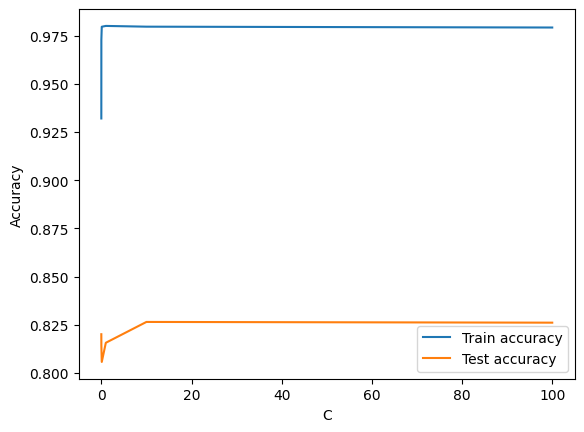

In [ ]:
# prompt: plot train and test accuracy vs C parameters

# Plot the train and test accuracy vs C parameters
plt.plot(grid_search.cv_results_['param_C'], grid_search.cv_results_['mean_train_score'], label='Train accuracy')
plt.plot(grid_search.cv_results_['param_C'], grid_search.cv_results_['mean_test_score'], label='Test accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#lgr with best hyperparameter
best_lgr = grid_search.best_estimator_

In [ ]:
# prompt: save best_lgr at current directory

import pickle
with open("best_lgr.pkl", "wb") as f:
    pickle.dump(best_lgr, f)


In [ ]:
# prompt: load best_lgr above saved

with open("best_lgr.pkl", "rb") as f:
    best_lgr = pickle.load(f)


## Performance of lgr model

In [ ]:
#train predicted probability
train_proba = best_lgr.predict_proba(X_train_bow)

#test predicted probability
test_proba = best_lgr.predict_proba(X_test_bow)

In [ ]:
#train predicted
y_train_predict = best_lgr.predict(X_train_bow)

#test predicted
y_test_predict = best_lgr.predict(X_test_bow)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#accuracy score on the train data
accuracy_score(y_train, y_train_predict)

0.9749327998999813

In [ ]:
#accuracy score on the test data
accuracy_score(y_test, y_test_predict)

0.82075

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import numpy as np

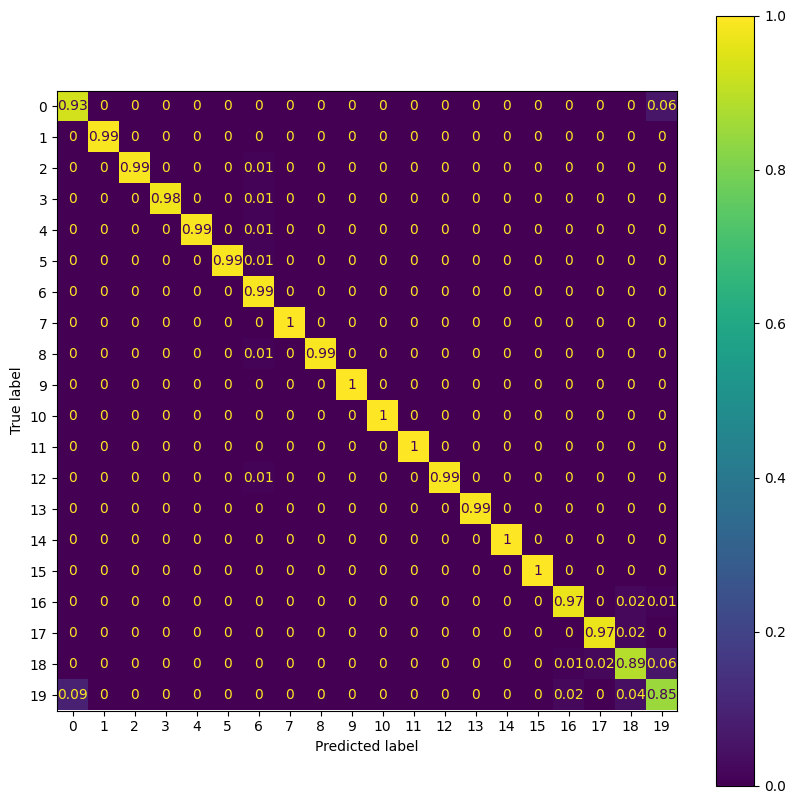

In [ ]:
# prompt: same above plot on the train data but display of larger size

cm_tr = confusion_matrix(y_train, y_train_predict, normalize='true')
cm_tr = np.around(cm_tr, decimals=2)
disp = ConfusionMatrixDisplay(cm_tr)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()


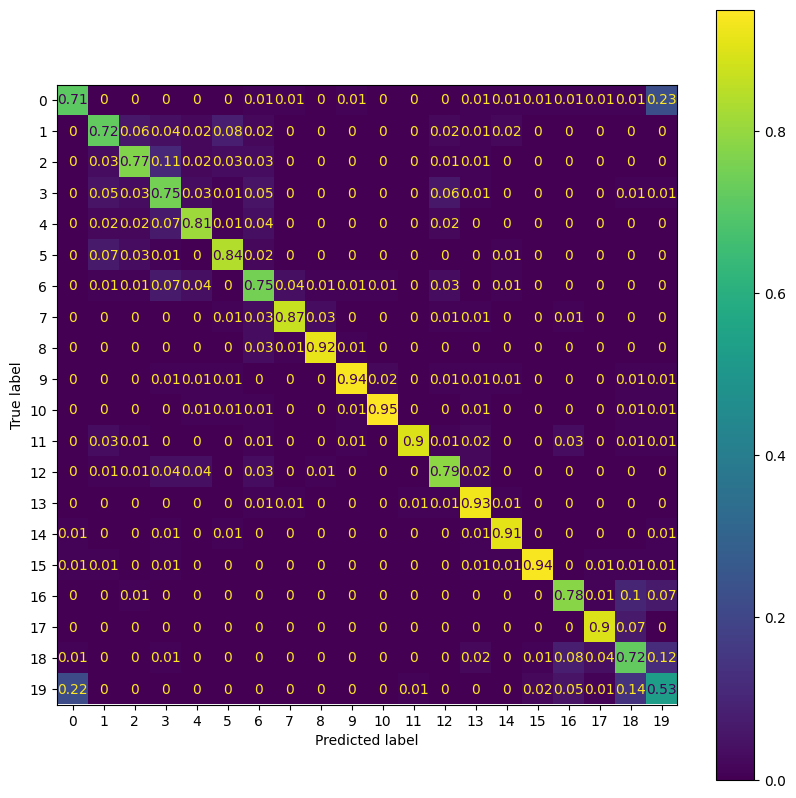

In [ ]:
cm_te = confusion_matrix(y_test, y_test_predict, normalize='true')
cm_te = np.around(cm_te, decimals=2)
disp = ConfusionMatrixDisplay(cm_te)


# Set the figure size
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

**Observation:**



Purpose of applying model is just having a reference of a base model so that I can compare. We are here kind of overfitting i.e. train accuracy 97% and test accuracy 82%. Original class 19 having very low test accuracy i.e. only 53% are truely predicted.



**The end**